### Запустим парсинг вакансий аналитика данных на hh.ru

In [1]:
# Парсим вакансии с hh.ru
# Если хотим получить вакансии со всей России указываем 'area':{'113'}; 
# Если хотим получить выборку по некоторым регионам, то 'area':{'72', '3', '61', '96', '78', '66', '88', '54'}
# Импортируем бибилиотеки
import requests
import pandas as pd

# Указываем количество страниц, которые хотим спарсить
number_of_pages = 100

# Задаем название позиций, по которым хотим спарсить вакансии
job_title = ["'Data Analyst' and 'Аналитик данных'"]
# Запускаем цикл, в котором проходим по страницам и записываем данные в Data_Frame
for job in job_title:
    data=[]
    for i in range(number_of_pages):
        url = 'https://api.hh.ru/vacancies'
        par = {'text': job, 'area':{'113'}, 'per_page':'10', 'page':i}
        r = requests.get(url, params=par)
        e=r.json()
        data.append(e)
        vacancy_details = data[0]['items'][0].keys()
        df = pd.DataFrame(columns= list(vacancy_details))
        ind = 0
        for i in range(len(data)):
            for j in range(len(data[i]['items'])):
                df.loc[ind] = data[i]['items'][j]
                ind+=1
                
# Переименовываем колонку с названием позиции
df = df.rename(columns={'name':'job_title'})

# Колонку с данными о регионе / городе преобразуем из формата dict в обычную колонку, чтобы было удобно работать
df = pd.concat([df.drop(['area'], axis=1), df['area'].apply(pd.Series)], axis=1)

# Колонку с зарплатой тоже переводим из dict в обычную колонку 
df = pd.concat([df.drop(['salary'], axis=1), df['salary'].apply(pd.Series)], axis=1)

# Переименовываем колонки 
df = df.rename(columns={'name':'city', 'from':'salary_from', 'to':'salary_to'})

# Колонку с опытом работы также преобразуем из dict в обычную колонку 
df = pd.concat([df.drop(['experience'], axis=1), df['experience'].apply(pd.Series)], axis=1)
# Переименуем 
df = df.rename(columns={'name':'experience'})

# Оставим вакансии только с валютой RUR 
df = df.query('currency=="RUR"')

# Избавимся от лишних колонок и посмотрим, что получилось
df = df[['job_title', 'city', 'salary_from', 'salary_to', 'currency', 'experience']]
df.head(10)

,job_title,city,salary_from,salary_to,currency,experience
0,Data Analyst,Москва,230000.0,NaN,RUR,От 3 до 6 лет
1,Data Analyst (middle),Москва,180000.0,300000.0,RUR,От 1 года до 3 лет
3,Аналитик данных,Москва,230000.0,NaN,RUR,От 3 до 6 лет
6,Data Analyst (Senior/Lead),Москва,220000.0,300000.0,RUR,Более 6 лет
7,Дата-менеджер (Data-analyst по работе с основн...,Москва,120000.0,150000.0,RUR,От 1 года до 3 лет
10,BI аналитик,Москва,NaN,200000.0,RUR,От 1 года до 3 лет
11,Junior Data Analyst,Москва,NaN,150000.0,RUR,От 1 года до 3 лет
13,Аналитик данных (удаленно),Санкт-Петербург,80000.0,NaN,RUR,От 1 года до 3 лет
24,Junior Data scientist (Аналитик),Нижний Новгород,60000.0,NaN,RUR,Нет опыта
25,Data Analyst / Аналитик данных,Нижний Новгород,NaN,150000.0,RUR,От 1 года до 3 лет


In [2]:
# для salary_from и salary_to удаляем пропуски, сортируем значения и получаем медиану
salary_from = df.salary_from.dropna().sort_values()
salary_from_median = salary_from.median()
salary_to = df.salary_from.dropna().sort_values()
salary_to_median = salary_to.median()

# заполним пропуски медианным знаением salary_from
df['salary_from'] = df['salary_from'].fillna(salary_from_median)
# заполним пропуски медианным знаением salary_to
df['salary_to'] = df['salary_to'].fillna(salary_to_median)

In [3]:
# Получаем интервал средней зарплат аналитика данных по всей России
print('Средняя зарплата "от" для аналитика данных по всей России = {}'.format(round(df.salary_from.mean(), 2)))
print('Средняя зарплата "до" для аналитика данных по всей России = {}'.format(round(df.salary_to.mean(), 2)))

Средняя зарплата "от" для аналитика данных по всей России = 130858.57
Средняя зарплата "до" для аналитика данных по всей России = 170400.56


#### Посмотрим, какие вакансии для аналитика данных, но исключим вакансии Москвы

In [4]:
df_no_Moscow = df.query('city!="Москва"')

In [8]:
# для salary_from и salary_to удаляем пропуски, сортируем значения и получаем медиану
salary_from_no_Moscow = df_no_Moscow.salary_from.dropna().sort_values()
salary_from_no_Moscow_median = salary_from_no_Moscow.median()
salary_to_no_Moscow = df_no_Moscow.salary_from.dropna().sort_values()
salary_to_no_Moscow_median = salary_to_no_Moscow.median()

# заполним пропуски медианным знаением salary_from
df_no_Moscow['salary_from'] = df_no_Moscow['salary_from'].fillna(salary_from_no_Moscow_median)
# заполним пропуски медианным знаением salary_to
df_no_Moscow['salary_to'] = df_no_Moscow['salary_to'].fillna(salary_to_no_Moscow_median)

C:\Users\agladkih\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\agladkih\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [9]:
# Посмотрим описательные статистики для salary_from
df_no_Moscow['salary_from'].describe()
# До 60 тыс имеется только 25% вакансий
# 50% вакансий имеют salary более 100 тыс

count        65.000000
mean      99676.923077
std       53124.296375
min       35000.000000
25%       60000.000000
50%      100000.000000
75%      110000.000000
max      300000.000000
Name: salary_from, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001CCB4E15908>,
      dtype=object)

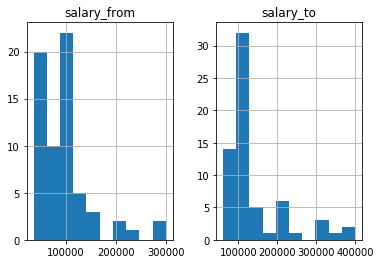

In [12]:
df_no_Moscow.hist()

In [10]:
# Посмотрим описательные статистики для salary_to
df_no_Moscow['salary_to'].describe()
# До 100 тыс имеется только 25% вакансий
# 50% вакансий имеют salary более 110 тыс
# Высокие значения у стандартного отклонения и видно, что между миниммальным и максимальным значением очень выокий разброс
# Учитывая такой большой разброс, можно отдельно провести анализ с учетом experience

count        65.000000
mean     138000.000000
std       76798.030574
min       60000.000000
25%      100000.000000
50%      110000.000000
75%      150000.000000
max      400000.000000
Name: salary_to, dtype: float64

In [6]:
# Получаем интервал средней зарплат аналитика данных исключая Москву
print('Средняя зарплата "от" для аналитика данных исключаяя Москву = {}'.format(round(df_no_Moscow.salary_from.mean(), 2)))
print('Средняя зарплата "до" для аналитика данных исключаяя Москву = {}'.format(round(df_no_Moscow.salary_to.mean(), 2)))

Средняя зарплата "от" для аналитика данных исключаяя Москву = 99676.92
Средняя зарплата "до" для аналитика данных исключаяя Москву = 138000.0
